In [1]:
from seagul.rl.ars.ars_pipe import ars
from seagul.nn import MLP
import torch
import matplotlib.pyplot as plt
from seagul.mesh import create_mesh, variation_dim, mesh_dim, create_mesh_dict, BylMesh
import time
import copy
import gym


import xarray as xr
import numpy as np
import pandas as pd

import os

from sklearn.decomposition import PCA

In [2]:
def identity(rews,obs,acts):
    return rews

def vardiv(rews, obs, acts):
    return rews/variation_dim(obs)

def varmul(rews, obs, acts):
    return rews*variation_dim(obs)

def rough_measure(x):
    d = torch.stack([x[t,:] - x[t-1,:] for t in range(1,x.shape[0])])
    return d.std()#$/(torch.abs(d.mean()))

def rmul(rews, obs, acts):
    return rews*rough_measure(obs)

def rdiv(rews, obs, acts):
    return rews/rough_measure(obs)

def do_rollout(env, policy, render=False):
    torch.autograd.set_grad_enabled(False)

    act_list = []
    obs_list = []
    rew_list = []

    dtype = torch.float32
    obs = env.reset()
    done = False
    cur_step = 0

    while not done:
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())

        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())
        if render:
            env.render()
            input("step?")
            #time.sleep(.05)

        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)

        cur_step += 1

    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_length


def do_long_rollout(env, policy, ep_length):
    torch.autograd.set_grad_enabled(False)

    act_list = []
    obs_list = []
    rew_list = []

    dtype = torch.float32
    obs = env.reset()
    done = False
    cur_step = 0

    while cur_step < ep_length:
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())

        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())

        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)

        cur_step += 1

    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_length

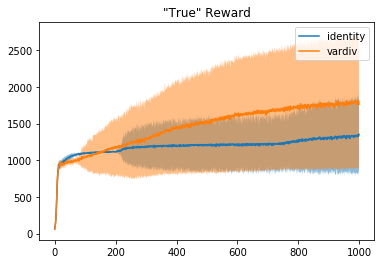

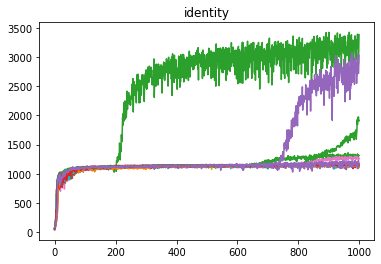

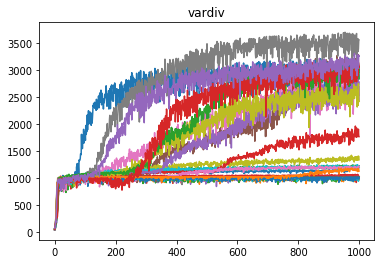

<Figure size 432x288 with 0 Axes>

In [3]:
data = torch.load("./data5/Hopper-v2.xr")

policy_dict = data.policy_dict
rews = data.rews
exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
num_seeds = len(policy_dict['identity'])

#policy_dict = torch.load("./data/mjw_longermul.pol_dict")
#rews = torch.load("./data/mjw_longermul.data")

means = rews.mean(dim="trial")
stds = rews.std(dim="trial")

plt.plot(means.T)
plt.legend(exp_names)
ci = stds

for mean, c in zip(means, ci):
    plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
plt.title("\"True\" Reward")
plt.figure()

for exp_name in exp_names:  
    plt.plot(rews.loc[exp_name].T)
    plt.title(exp_name)
    plt.figure()

cycles found:  11.0


PCA(n_components=5, svd_solver='arpack')

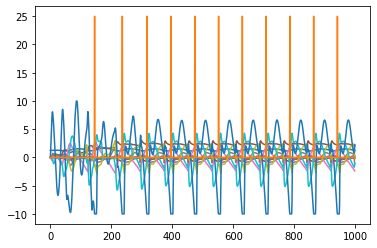

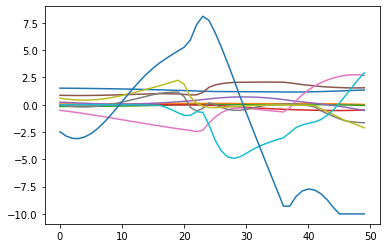

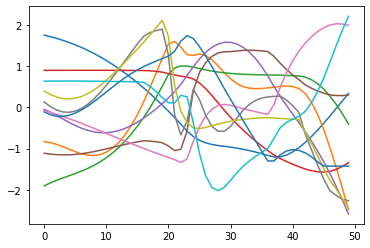

In [5]:
from sklearn.decomposition import PCA
env_name = "Hopper-v2"

policy = policy_dict['vardiv'][6]

env = gym.make(env_name)
obs,acts,rews,l = do_long_rollout(env, policy, ep_length= 1000)
#o,a,r,l = do_rollout(env, policy, render=True)

on = np.zeros(obs.shape[0])
for i,o in enumerate(obs):
    on[i] =  (o[3] < -.5 and o[9] > 0.0 and last_o[9] < 0.0)
    last_o = copy.deepcopy(o)

print("cycles found: ", sum(on))

start_idx = 100; end_idx = 150
plt.plot(obs)
plt.plot(on*25)
plt.figure()
plt.plot(obs[start_idx:end_idx])
plt.figure()
ref = np.array(obs[start_idx:end_idx],dtype=np.float64)
target = (ref - ref.mean(axis=0))/ref.std(axis=0)
target = copy.deepcopy(target) # Don't even ask
plt.plot(target)

pca = PCA(n_components=5, svd_solver='arpack')
pca.fit(target)

In [6]:
dl = []
last_seen = 0
for i,o in enumerate(on):
    if o == 1:
        dl.append(i-last_seen)
        last_seen = i
        
dd = {}
for d in dl:
    if (d) in dd: 
        dd[(d)] += 1
    else:
        dd[(d)] = 1
        
for thing in dd.items():
    print("spacing: ", thing[0], " frequency: ", thing[1])

spacing:  145  frequency:  1
spacing:  91  frequency:  1
spacing:  81  frequency:  1
spacing:  79  frequency:  1
spacing:  78  frequency:  7


In [27]:
np.cumsum(pca.explained_variance_ratio_)

array([0.43248708, 0.83823708, 0.9538687 , 0.9853836 , 0.99160104])

In [28]:
pca.singular_values_/pca.singular_values_.max()

array([1.        , 0.96859605, 0.51707286, 0.26994258, 0.1199    ])

In [60]:
# Hopper-v2

def my_reset(env, point):
    env.reset()
    qpos = np.concatenate((np.array([0.0]), point[:5]))
    qvel = point[5:]
    env.unwrapped.set_state(qpos, qvel)
    return env.unwrapped._get_obs()

def create_mesh_act(env, policy, d, seed_point, perturbs):
    torch.autograd.set_grad_enabled(False)
    
    failure_point = np.ones_like(seed_point)*10
    
    mesh = BylMesh(d) 
    mesh[failure_point] = [0, 0, failure_point]
    mesh[seed_point] = [1, 0, seed_point]

    
    mesh_points = []
    mesh_points.append(failure_point)
    mesh_points.append(seed_point)
    
    transition_list = [[0]*len(perturbs)] #Failure state always transitions to itself
    
    cnt = 0; cur_explored_cnt = 0
    for init_pos in mesh_points:
        if (init_pos == failure_point).all():
            continue
        
        cur_explored_cnt += 1
        cur_mesh_pnt = len(mesh_points)
        transition_list.append([])

        tmp_points = []
        tmp_keys = []
        failed = False

        for pert in perturbs:
            if failed:
                break
            cnt+=1


            step = 0
            done = False; 
            do_once=1 
            o = my_reset(env, init_pos)

            while not done:
                a = policy(o) + do_once*pert
                step+=1
                do_once=0
                
                last_o = copy.copy(o)

                o, r, done, _ = env.step(a.numpy())

                
                if(o[3] < -.5 and o[9] > 0.0 and last_o[9] < 0.0 and step > 5):
                    m = o[9] - last_o[9]
                    b = last_o[9]
                    tcross = -b/m
                    pt = last_o + tcross*(o - last_o)
                                    
                    key = (pt - ref.mean(axis=0))/ref.std(axis=0)
                    
                    #weights = pca.singular_values_/pca.singular_values_.max()
                    #key = weights*pca.transform(key.reshape(1,-1)).reshape(-1)

                    tmp_points.append(copy.copy(pt))
                    tmp_keys.append(copy.copy(key))

                    if cnt % 1000 == 0:
                        print("explored: ", cur_explored_cnt, "| added: ", len(mesh), "| ratio: ", cur_explored_cnt/len(mesh), "| failures: ", mesh[failure_point][1], "| count: ", cnt)
                    done=True
                        
                if step > 200:
                    failed=True
                    done=True
                    
        if not failed:
            for p,k in zip(tmp_points, tmp_keys):
                if k in mesh:
                    mesh[k][1] += 1
                else:
                    mesh_points.append(p)
                    mesh[k] = [1, len(mesh_points), p]
                    
                transition_list[-1].append(mesh[k][1])


        else:
            for _ in range(len(perturbs)):
                mesh[failure_point][1] += 1
                transition_list[-1].append(mesh[failure_point][0])

  
    torch.autograd.set_grad_enabled(True)
    return mesh, mesh_points, np.array(transition_list)


In [ ]:
perts =  np.random.uniform(-.1,.1,(20,3))
#perts =  np.zeros((20,3))
policy = policy_dict['vardiv'][6]
o = env.reset()
last_o = copy.copy(o)
seed_point=None
step = 0
done=False


while not done:
    a = policy(o).detach(); step+=1
    o, r, done, _ = env.step(a.numpy())
    if (o[3] < -.5 and o[9] > 0.0 and last_o[9] < 0.0 and step > 100):
        seed_point = o
        done=True
    last_o = copy.copy(o)

print(seed_point)

mesh, mesh_points, T = create_mesh_act(env, policy, .05, seed_point, perts)

[  1.27112659   0.0689441   -0.02306396  -0.55655391  -0.19030214
   1.60014353   2.61269631  -1.43075492  -1.36502345   0.56949428
 -10.        ]
explored:  50 | added:  154 | ratio:  0.3246753246753247 | failures:  0 | count:  1000
explored:  100 | added:  267 | ratio:  0.37453183520599254 | failures:  0 | count:  2000
explored:  150 | added:  369 | ratio:  0.4065040650406504 | failures:  0 | count:  3000
explored:  200 | added:  407 | ratio:  0.4914004914004914 | failures:  0 | count:  4000
explored:  250 | added:  436 | ratio:  0.573394495412844 | failures:  0 | count:  5000
explored:  300 | added:  487 | ratio:  0.6160164271047228 | failures:  0 | count:  6000
explored:  350 | added:  516 | ratio:  0.6782945736434108 | failures:  0 | count:  7000
explored:  400 | added:  537 | ratio:  0.74487895716946 | failures:  0 | count:  8000
explored:  450 | added:  557 | ratio:  0.8078994614003591 | failures:  0 | count:  9000
explored:  500 | added:  598 | ratio:  0.8361204013377926 | fail

In [13]:
failure_point = np.ones_like(seed_point)*10
print(len(mesh[failure_point]))
print(len(mesh))
print(len(mesh_points))

3
154
153


In [54]:
from scipy import sparse 
Ts = sparse.lil_matrix((T.shape[0], T.shape[0]))
for i,t in enumerate(T):
    #print(i)
    for e in t:
        Ts[i,e-1] += 1/len(t)
    

In [55]:
w,v = sparse.linalg.eigs(Ts,k=10)

In [58]:
w

array([ 1.        +0.j        , -0.3108822 +0.52807785j,
       -0.3108822 -0.52807785j,  0.53518244+0.j        ,
        0.45904201+0.20991577j,  0.45904201-0.20991577j,
       -0.52976343+0.14045306j, -0.52976343-0.14045306j,
       -0.08342055+0.29373656j, -0.08342055-0.29373656j])

In [57]:
np.abs(w)

array([1.        , 0.61279194, 0.61279194, 0.53518244, 0.50476152,
       0.50476152, 0.54806601, 0.54806601, 0.30535251, 0.30535251])